<a href="https://colab.research.google.com/github/dieund/CS2225.CH1501/blob/master/NhanDienCMND.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package pytesseract
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 14 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (16.4 MB/s)
Selecting previously unselect

In [4]:
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=c89b110fbe0846288243c5f2c75e45b857cfe511a6bbb049c70578e70d8d43ce
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract


In [2]:
!git clone https://github.com/dieund/CS2225.CH1501/
%cd CS2225.CH1501

Cloning into 'CS2225.CH1501'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 185 (delta 28), reused 128 (delta 3), pack-reused 0
Receiving objects: 100% (185/185), 35.24 MiB | 11.76 MiB/s, done.
Resolving deltas: 100% (28/28), done.
/content/CS2225.CH1501


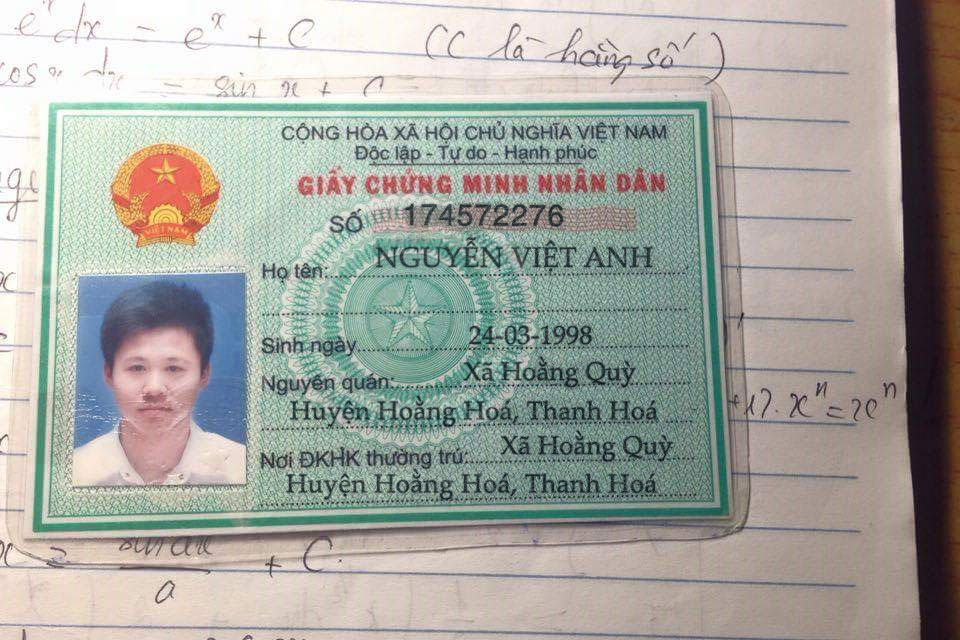

============ Hinh anh khu vuc ID =================


================ Ket qua =============
174572276

Khong co trong danh sach


In [6]:
import pytesseract
from PIL import Image
from google.colab.patches import cv2_imshow
import os
import numpy as np
import tensorflow as tf
import cv2
from utils import load_label_map
from utils.image_utils import non_max_suppression_fast

class Detector(object):
    def __init__(self, path_to_model, path_to_labels, nms_threshold=0.15, score_threshold=0.3):
        self.path_to_model = path_to_model
        self.path_to_labels = path_to_labels
        self.category_index = load_label_map.create_category_index_from_labelmap(path_to_labels, use_display_name=True)
        self.nms_threshold = nms_threshold
        self.score_threshold = score_threshold

        # load model
        self.interpreter = self.load_model()

        # Get input and output tensors.
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

        self.detection_scores = None
        self.detection_boxes = None
        self.detection_classes = None

    def load_model(self):
        # Load the TFLite model and allocate tensors.
        interpreter = tf.lite.Interpreter(model_path=self.path_to_model)
        interpreter.allocate_tensors()

        return interpreter

    def predict(self, img):
        original = img
        height = self.input_details[0]['shape'][1]
        width = self.input_details[0]['shape'][2]
        img = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)
        img = np.expand_dims(img, axis=0)

        # Normalize input data
        input_mean = 127.5
        input_std = 127.5
        input_data = (np.float32(img) - input_mean) / input_std
        self.interpreter.set_tensor(self.input_details[0]['index'], input_data)

        self.interpreter.invoke()

        # Retrieve detection results
        self.detection_boxes = self.interpreter.get_tensor(self.output_details[0]['index'])[
            0]  # Bounding box coordinates of detected objects
        self.detection_classes = self.interpreter.get_tensor(self.output_details[1]['index'])[
            0]  # Class index of detected objects
        self.detection_scores = self.interpreter.get_tensor(self.output_details[2]['index'])[
            0]  # Confidence of detected objects

        mask = np.array(self.detection_scores) > self.score_threshold
        self.detection_boxes = np.array(self.detection_boxes)[mask]
        self.detection_classes = np.array(self.detection_classes)[mask]

        self.detection_classes += 1

        # Convert coordinate to original coordinate
        h, w, _ = original.shape
        self.detection_boxes[:, 0] = self.detection_boxes[:, 0] * h
        self.detection_boxes[:, 1] = self.detection_boxes[:, 1] * w
        self.detection_boxes[:, 2] = self.detection_boxes[:, 2] * h
        self.detection_boxes[:, 3] = self.detection_boxes[:, 3] * w

        # Apply non-max suppression
        self.detection_boxes, self.detection_classes = non_max_suppression_fast(boxes=self.detection_boxes,
                                                                                labels=self.detection_classes,
                                                                                overlapThresh=self.nms_threshold)
        return self.detection_boxes, np.array(self.detection_classes).astype("int"), self.category_index

    def draw(self, image):
        self.detection_boxes, self.detection_classes, self.category_index = self.predict(image)
        height, width, _ = image.shape

        for i in range(len(self.detection_classes)):            
            label = str(self.category_index[self.detection_classes[i]]['name'])
            if label == 'id':
              real_ymin = int(max(1, self.detection_boxes[i][0]))
              real_xmin = int(max(1, self.detection_boxes[i][1]))
              real_ymax = int(min(height, self.detection_boxes[i][2]))
              real_xmax = int(min(width, self.detection_boxes[i][3]))

              real_height = real_ymax - real_ymin
              real_width =  real_xmax - real_xmin

              crop_img = image[real_ymin:real_ymin+real_height, real_xmin:real_xmin+real_width]

              return crop_img

detection_model = Detector(path_to_model='./config_text_detection/model.tflite',
                           path_to_labels='./config_text_detection/label_map.pbtxt',
                           nms_threshold=0.2, score_threshold=0.3)
img = cv2.imread('cmnd1.jpg')
cv2_imshow(img)
IDImg = detection_model.draw(img)
print('============ Hinh anh khu vuc ID =================')
cv2_imshow(IDImg)


gray = cv2.cvtColor(IDImg, cv2.COLOR_BGR2GRAY) #convert to grey to reduce detials
gray = cv2.bilateralFilter(gray, 11, 17, 17) #Blur to reduce noise

filename = "{}.png".format(os.getpid())
cv2.imwrite(filename, gray)

text = pytesseract.image_to_string(Image.open(filename))
# Xóa ảnh tạm sau khi nhận dạng
os.remove(filename)
# In dòng chữ nhận dạng được
print('================ Ket qua =============')
print(text)
if text == "174572276":
  print('Duoc vao')
else:
  print('Khong co trong danh sach')



